In [13]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from kmodes import kmodes
from kmodes.kmodes import KModes

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy import spatial

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)
seed = 123

In [2]:
with open('../data/interim/df.pkl', 'rb') as read_file:
    df = pickle.load(read_file)

In [126]:
df.head(1)

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,duration_category,balance_category,is_second_half_of_month,pdays_category,new_customers,total_duration,total_duration_category,prev_engagement_category,current_engagement_category
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,"[50, 60)",4,1,2,0,1,0,2,5,3,0,"[180, 300)","[500, 3000)",0,"[-1, 0)",1,261,"[180, 600)","[0, 1)","[1, 6)"


In [127]:
df.shape
variables = df.columns.tolist()


(45211, 38)

### Applied K-modes clustering to segment the customers into different profiles

In [3]:
num_features = df.select_dtypes(include = ['float64', 'int64', 'category']).columns.tolist()
# num_features
list_of_features = [
 'age_group',
 'job_label_encoded',
 'marital_label_encoded',
 'education_label_encoded',
 'default_label_encoded',
 'housing_label_encoded',
 'loan_label_encoded',
 'contact_label_encoded',
 'month_label_encoded',
 'poutcome_label_encoded',
 'duration_category',
 'balance_category',
 'is_second_half_of_month',
'pdays_category',
 'new_customers',
 'total_duration_category',
 'prev_engagement_category',
 'current_engagement_category']

In [4]:
#create dummy variables
for feature in list_of_features:
#     list_of_features_list = f'list_of_features_{feature}'
    list_of_features_list = pd.get_dummies(df[feature], prefix = feature)
    df1 = df.join(list_of_features_list)
    df = df1
    
df_list_of_features = df1.columns.values.tolist()
to_keep = [i for i in df_list_of_features if i not in list_of_features]
#final data col
df_final = df[to_keep]

df_final.head()
df_final.shape

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,y_label_encoded,total_duration,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)"
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0,261,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0,151,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0,76,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0,92,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0,198,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0


(45211, 94)

In [6]:
#transform demogs into numpy array
clustering_features = df_final.iloc[:,20:]
clustering_features.head()
#Split the data 60 - 20 - 20 train/val/test. Apply the centroids from train set on validation and test set 

X_train_val, X_test = train_test_split(clustering_features, test_size=0.2,random_state=seed)
X_train, X_val = train_test_split(X_train_val, test_size=.25, random_state=seed)

X_train_features = np.array(X_train)


,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)"
0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0


In [10]:
with open('../data/processed/clustering_features.pkl', 'wb') as to_write: #dummied clustering features
    pickle.dump(clustering_features, to_write) 

In [7]:
cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 10, verbose=10, random_state = seed)
    kmode.fit_predict(X_train_features)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 334842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 334842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 334842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 334842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 334842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 334842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 334842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, ite

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4825, cost: 318279.0
Run 1, iteration: 2/100, moves: 0, cost: 318279.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8065, cost: 307018.0
Run 2, iteration: 2/100, moves: 0, cost: 307018.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5182, cost: 314640.0
Run 3, iteration: 2/100, moves: 0, cost: 314640.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 5947, cost: 305058.0
Run 4, iteration: 2/100, moves: 0, cost: 305058.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11306, cost: 311278.0
Run 5, iteration: 2/100, moves: 0, cost: 311278.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 

array([1, 1, 1, ..., 1, 1, 1], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3770, cost: 302192.0
Run 1, iteration: 2/100, moves: 0, cost: 302192.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4970, cost: 295757.0
Run 2, iteration: 2/100, moves: 903, cost: 295757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6762, cost: 290995.0
Run 3, iteration: 2/100, moves: 0, cost: 290995.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6891, cost: 291654.0
Run 4, iteration: 2/100, moves: 1796, cost: 291654.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 10064, cost: 295906.0
Run 5, iteration: 2/100, moves: 1908, cost: 295906.0
Init: initializing centroids
Init: initializing clusters
Starting iterations

array([0, 1, 0, ..., 0, 1, 1], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10903, cost: 285551.0
Run 1, iteration: 2/100, moves: 4203, cost: 285551.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7931, cost: 285206.0
Run 2, iteration: 2/100, moves: 0, cost: 285206.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8061, cost: 280894.0
Run 3, iteration: 2/100, moves: 2110, cost: 280894.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 7676, cost: 280250.0
Run 4, iteration: 2/100, moves: 1762, cost: 280250.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9160, cost: 285015.0
Run 5, iteration: 2/100, moves: 2526, cost: 285015.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

array([3, 3, 3, ..., 3, 3, 2], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10048, cost: 274680.0
Run 1, iteration: 2/100, moves: 3041, cost: 274620.0
Run 1, iteration: 3/100, moves: 1022, cost: 274620.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7490, cost: 278905.0
Run 2, iteration: 2/100, moves: 3303, cost: 275285.0
Run 2, iteration: 3/100, moves: 1712, cost: 273386.0
Run 2, iteration: 4/100, moves: 632, cost: 273386.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9083, cost: 278287.0
Run 3, iteration: 2/100, moves: 1211, cost: 278287.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10104, cost: 275475.0
Run 4, iteration: 2/100, moves: 2198, cost: 275475.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration

array([2, 0, 0, ..., 2, 0, 0], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9475, cost: 275997.0
Run 1, iteration: 2/100, moves: 0, cost: 275997.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8886, cost: 266552.0
Run 2, iteration: 2/100, moves: 1976, cost: 266552.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10381, cost: 279863.0
Run 3, iteration: 2/100, moves: 1059, cost: 279863.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9742, cost: 273769.0
Run 4, iteration: 2/100, moves: 1971, cost: 273769.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 8543, cost: 255154.0
Run 5, iteration: 2/100, moves: 2389, cost: 255154.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

array([3, 4, 0, ..., 3, 1, 4], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7950, cost: 267877.0
Run 1, iteration: 2/100, moves: 2822, cost: 266218.0
Run 1, iteration: 3/100, moves: 1416, cost: 266218.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9848, cost: 265124.0
Run 2, iteration: 2/100, moves: 2443, cost: 263880.0
Run 2, iteration: 3/100, moves: 227, cost: 263880.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7706, cost: 267696.0
Run 3, iteration: 2/100, moves: 2171, cost: 266889.0
Run 3, iteration: 3/100, moves: 415, cost: 266889.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10355, cost: 268575.0
Run 4, iteration: 2/100, moves: 0, cost: 268575.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/1

array([2, 2, 2, ..., 2, 2, 1], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10646, cost: 261869.0
Run 1, iteration: 2/100, moves: 3183, cost: 260608.0
Run 1, iteration: 3/100, moves: 1168, cost: 260608.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8544, cost: 264739.0
Run 2, iteration: 2/100, moves: 0, cost: 264739.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9540, cost: 263553.0
Run 3, iteration: 2/100, moves: 754, cost: 263553.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10066, cost: 266019.0
Run 4, iteration: 2/100, moves: 1928, cost: 266019.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9820, cost: 264665.0
Run 5, iteration: 2/100, moves: 593, cost: 264665.0
Init: initializing c

array([3, 5, 0, ..., 5, 5, 6], dtype=uint16)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9225, cost: 260586.0
Run 1, iteration: 2/100, moves: 2714, cost: 259547.0
Run 1, iteration: 3/100, moves: 824, cost: 259547.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8474, cost: 256213.0
Run 2, iteration: 2/100, moves: 34, cost: 256213.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8548, cost: 256967.0
Run 3, iteration: 2/100, moves: 1977, cost: 256967.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8718, cost: 266087.0
Run 4, iteration: 2/100, moves: 2499, cost: 266087.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 10357, cost: 260620.0
Run 5, iteration: 2/100, moves: 0, cost: 260620.0
Init: initializing cen

array([3, 2, 1, ..., 8, 2, 0], dtype=uint16)

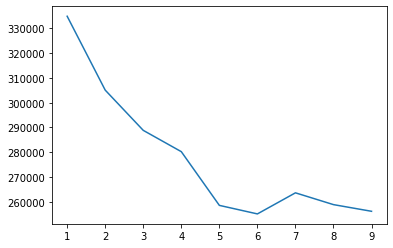

In [8]:
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)

(-0.1, 1)

(0, 27156)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4825, cost: 318279.0
Run 1, iteration: 2/100, moves: 0, cost: 318279.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8065, cost: 307018.0
Run 2, iteration: 2/100, moves: 0, cost: 307018.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 5182, cost: 314640.0
Run 3, iteration: 2/100, moves: 0, cost: 314640.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 5947, cost: 305058.0
Run 4, iteration: 2/100, moves: 0, cost: 305058.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11306, cost: 311278.0
Run 5, iteration: 2/100, moves: 0, cost: 311278.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 

Text(-0.05, 5758.0, '0')

Text(-0.05, 19331.0, '1')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27166)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3770, cost: 302192.0
Run 1, iteration: 2/100, moves: 0, cost: 302192.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4970, cost: 295757.0
Run 2, iteration: 2/100, moves: 903, cost: 295757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6762, cost: 290995.0
Run 3, iteration: 2/100, moves: 0, cost: 290995.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6891, cost: 291654.0
Run 4, iteration: 2/100, moves: 1796, cost: 291654.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 10064, cost: 295906.0
Run 5, iteration: 2/100, moves: 1908, cost: 295906.0
Init: initializing centroids
Init: initializing clusters
Starting iterations

Text(-0.05, 4908.5, '0')

Text(-0.05, 14805.0, '1')

Text(-0.05, 23479.5, '2')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27176)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10903, cost: 285551.0
Run 1, iteration: 2/100, moves: 4203, cost: 285551.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7931, cost: 285206.0
Run 2, iteration: 2/100, moves: 0, cost: 285206.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8061, cost: 280894.0
Run 3, iteration: 2/100, moves: 2110, cost: 280894.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 7676, cost: 280250.0
Run 4, iteration: 2/100, moves: 1762, cost: 280250.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9160, cost: 285015.0
Run 5, iteration: 2/100, moves: 2526, cost: 285015.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

Text(-0.05, 4061.0, '0')

Text(-0.05, 11311.0, '1')

Text(-0.05, 17948.0, '2')

Text(-0.05, 24281.0, '3')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27186)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10048, cost: 274680.0
Run 1, iteration: 2/100, moves: 3041, cost: 274620.0
Run 1, iteration: 3/100, moves: 1022, cost: 274620.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7490, cost: 278905.0
Run 2, iteration: 2/100, moves: 3303, cost: 275285.0
Run 2, iteration: 3/100, moves: 1712, cost: 273386.0
Run 2, iteration: 4/100, moves: 632, cost: 273386.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9083, cost: 278287.0
Run 3, iteration: 2/100, moves: 1211, cost: 278287.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10104, cost: 275475.0
Run 4, iteration: 2/100, moves: 2198, cost: 275475.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration

Text(-0.05, 3776.5, '0')

Text(-0.05, 10837.5, '1')

Text(-0.05, 16773.0, '2')

Text(-0.05, 21027.5, '3')

Text(-0.05, 24908.5, '4')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27196)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9475, cost: 275997.0
Run 1, iteration: 2/100, moves: 0, cost: 275997.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8886, cost: 266552.0
Run 2, iteration: 2/100, moves: 1976, cost: 266552.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10381, cost: 279863.0
Run 3, iteration: 2/100, moves: 1059, cost: 279863.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9742, cost: 273769.0
Run 4, iteration: 2/100, moves: 1971, cost: 273769.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 8543, cost: 255154.0
Run 5, iteration: 2/100, moves: 2389, cost: 255154.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

Text(-0.05, 1994.5, '0')

Text(-0.05, 7038.0, '1')

Text(-0.05, 12054.0, '2')

Text(-0.05, 15705.0, '3')

Text(-0.05, 19970.5, '4')

Text(-0.05, 24869.0, '5')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27206)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7950, cost: 267877.0
Run 1, iteration: 2/100, moves: 2822, cost: 266218.0
Run 1, iteration: 3/100, moves: 1416, cost: 266218.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9848, cost: 265124.0
Run 2, iteration: 2/100, moves: 2443, cost: 263880.0
Run 2, iteration: 3/100, moves: 227, cost: 263880.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7706, cost: 267696.0
Run 3, iteration: 2/100, moves: 2171, cost: 266889.0
Run 3, iteration: 3/100, moves: 415, cost: 266889.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10355, cost: 268575.0
Run 4, iteration: 2/100, moves: 0, cost: 268575.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/1

Text(-0.05, 1802.5, '0')

Text(-0.05, 5746.0, '1')

Text(-0.05, 10561.5, '2')

Text(-0.05, 14665.5, '3')

Text(-0.05, 17997.5, '4')

Text(-0.05, 21555.0, '5')

Text(-0.05, 25208.0, '6')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27216)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10646, cost: 261869.0
Run 1, iteration: 2/100, moves: 3183, cost: 260608.0
Run 1, iteration: 3/100, moves: 1168, cost: 260608.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8544, cost: 264739.0
Run 2, iteration: 2/100, moves: 0, cost: 264739.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9540, cost: 263553.0
Run 3, iteration: 2/100, moves: 754, cost: 263553.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10066, cost: 266019.0
Run 4, iteration: 2/100, moves: 1928, cost: 266019.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9820, cost: 264665.0
Run 5, iteration: 2/100, moves: 593, cost: 264665.0
Init: initializing c

Text(-0.05, 2301.0, '0')

Text(-0.05, 6651.0, '1')

Text(-0.05, 10346.0, '2')

Text(-0.05, 14237.0, '3')

Text(-0.05, 18009.5, '4')

Text(-0.05, 21115.0, '5')

Text(-0.05, 24293.0, '6')

Text(-0.05, 26549.5, '7')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

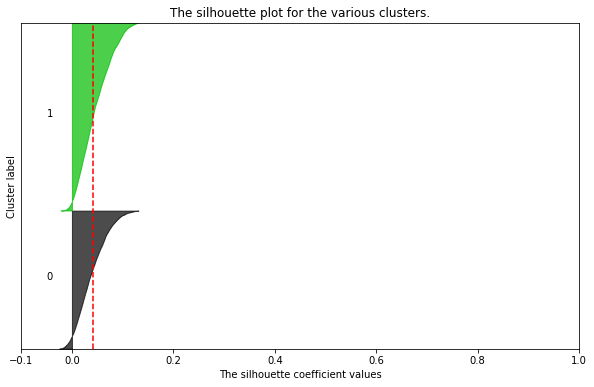

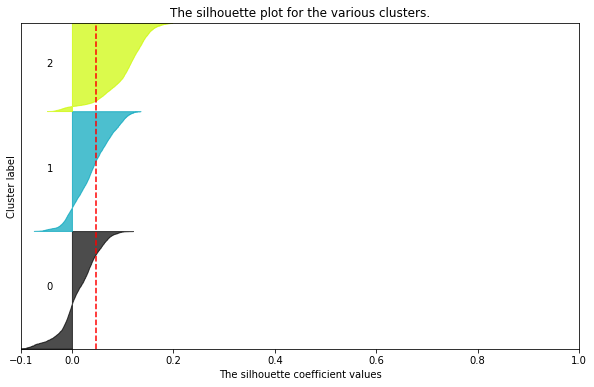

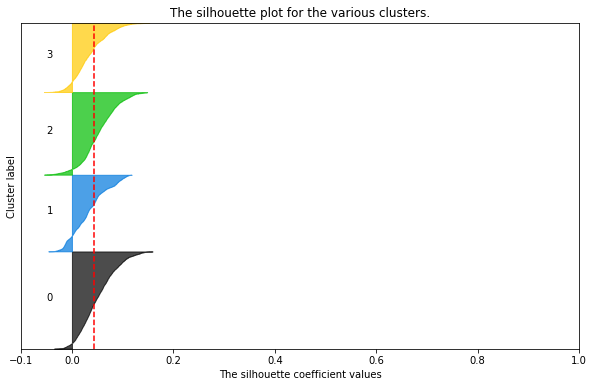

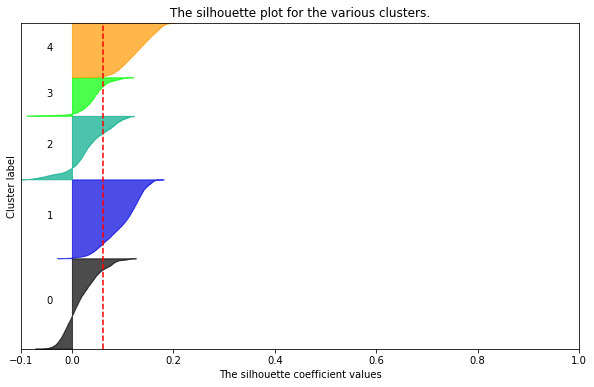

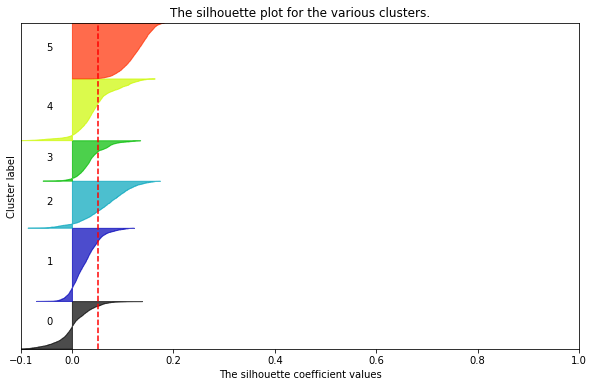

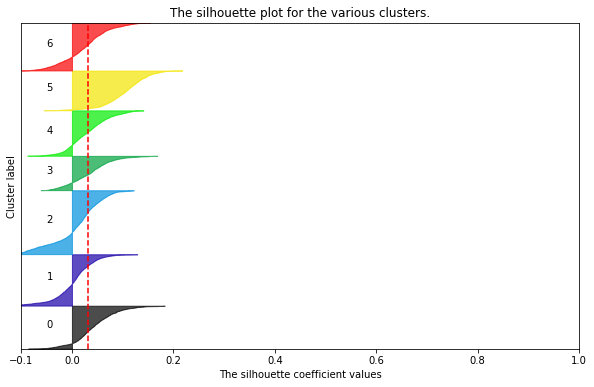

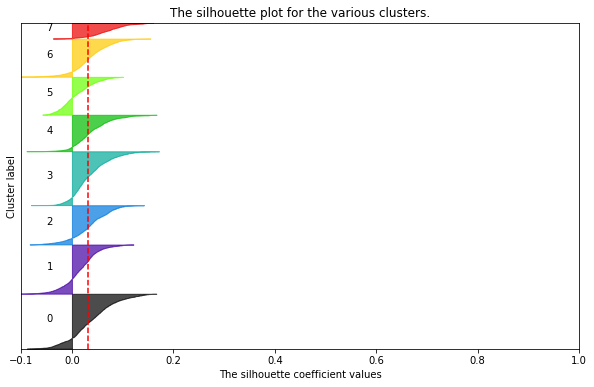

In [9]:
for n_clusters in list(range(2,9)):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111) 
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_train_features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KModes(n_clusters=n_clusters, init = "Huang", n_init = 10, verbose=10, random_state = seed)
    cluster_labels = clusterer.fit_predict(X_train_features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

In [11]:
# fit the train set into 5 clusters
km_huang5 = kmodes.KModes(n_clusters=5, init='Huang', n_init=10, verbose=10, random_state = seed)

# Predicted Clusters
clusters5 = km_huang5.fit_predict(X_train_features)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10048, cost: 274680.0
Run 1, iteration: 2/100, moves: 3041, cost: 274620.0
Run 1, iteration: 3/100, moves: 1022, cost: 274620.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7490, cost: 278905.0
Run 2, iteration: 2/100, moves: 3303, cost: 275285.0
Run 2, iteration: 3/100, moves: 1712, cost: 273386.0
Run 2, iteration: 4/100, moves: 632, cost: 273386.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9083, cost: 278287.0
Run 3, iteration: 2/100, moves: 1211, cost: 278287.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10104, cost: 275475.0
Run 4, iteration: 2/100, moves: 2198, cost: 275475.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration

In [26]:
train_cluster_predicted_df = pd.DataFrame(columns = clustering_features.columns, data = km_huang5.cluster_centroids_)
train_cluster_predicted_df['cluster_predicted'] = np.arange(0,5)
train_cluster_predicted_df

,"age_group_[10, 20)","age_group_[20, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 70)","age_group_[70, 80)","age_group_[80, 90)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4918)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 10212)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 400)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60170)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 275)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 63)",cluster_predicted
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,4


In [12]:
cluster_centroids_df = pd.DataFrame(columns = clustering_features.columns, data = km_huang5.cluster_centroids_)
cluster_centroids_df

,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0


In [31]:
# with open('../models/cluster_centroids_df.pkl', 'wb') as to_write: 
#     pickle.dump(cluster_centroids_df, to_write)

In [14]:
train_val, test = train_test_split(df, test_size=0.2,random_state=seed)
train, val = train_test_split(train_val, test_size=.25, random_state=seed)

In [15]:
train_copy = train.copy().reset_index()
train_copy = train_copy.drop('level_0', axis = 1)
train_copy.head()

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)"
0,23354,39,management,single,tertiary,no,816,yes,no,cellular,27,aug,37,3,-1,0,unknown,no,"[30, 40)",4,2,2,0,1,0,0,8,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",111,"[0, 180)","[0, 60)",1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,18555,41,services,married,secondary,no,56,yes,no,cellular,31,jul,63,21,-1,0,unknown,no,"[40, 50)",7,1,1,0,1,0,0,7,3,0,"[0, 500)","[10, 64)","[-1, 0)","[0, 1)",1323,"[600, 60171)","[60, 180)",1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1
2,39190,27,blue-collar,single,secondary,no,179,yes,no,cellular,18,may,74,2,-1,0,unknown,no,"[10, 30)",1,2,1,0,1,0,0,5,3,0,"[0, 500)","[1, 6)","[-1, 0)","[0, 1)",148,"[0, 180)","[60, 180)",1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
3,26580,32,services,married,secondary,no,983,yes,no,cellular,20,nov,500,2,133,1,failure,yes,"[30, 40)",7,1,1,0,1,0,0,11,0,1,"[500, 3000)","[1, 6)","[0, 180)","[1, 6)",1000,"[600, 60171)","[300, 4919)",1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0
4,16196,42,blue-collar,married,primary,no,-119,yes,no,cellular,22,jul,167,3,-1,0,unknown,no,"[40, 50)",1,1,0,0,1,0,0,7,3,0,"[-8019, 0)","[1, 6)","[-1, 0)","[0, 1)",501,"[180, 600)","[60, 180)",1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,

In [16]:
#combine cluster_centroid with original train df
clusters5_train_df = pd.DataFrame(clusters5)
len(clusters5_train_df) == len(train_copy)

clusters5_train_df.columns = ['cluster_predicted']

combinedclusters5_train_df = pd.concat([train_copy, clusters5_train_df], axis = 1).reset_index()

combinedclusters5_train_df.head()
len(combinedclusters5_train_df) == len(clusters5_train_df)

True

,level_0,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)",cluster_predicted
0,0,23354,39,management,single,tertiary,no,816,yes,no,cellular,27,aug,37,3,-1,0,unknown,no,"[30, 40)",4,2,2,0,1,0,0,8,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",111,"[0, 180)","[0, 60)",1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,2
1,1,18555,41,services,married,secondary,no,56,yes,no,cellular,31,jul,63,21,-1,0,unknown,no,"[40, 50)",7,1,1,0,1,0,0,7,3,0,"[0, 500)","[10, 64)","[-1, 0)","[0, 1)",1323,"[600, 60171)","[60, 180)",1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0
2,2,39190,27,blue-collar,single,secondary,no,179,yes,no,cellular,18,may,74,2,-1,0,unknown,no,"[10, 30)",1,2,1,0,1,0,0,5,3,0,"[0, 500)","[1, 6)","[-1, 0)","[0, 1)",148,"[0, 180)","[60, 180)",1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0
3,3,26580,32,services,married,secondary,no,983,yes,no,cellular,20,nov,500,2,133,1,failure,yes,"[30, 40)",7,1,1,0,1,0,0,11,0,1,"[500, 3000)","[1, 6)","[0, 180)","[1, 6)",1000,"[600, 60171)","[300, 4919)",1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,4
4,4,16196,42,blue-collar,married,primary,no,-119,yes,no,cellular,22,jul,167,3,-1,0,unknown,no,"[40, 50)",1,1,0,0,1,0,0,7,3,0,"[-8019, 0)","[1, 6)","[-1, 0)","[0, 1)",501,"[180, 600)","[60

True

In [96]:
val.head()

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,duration_category,balance_category,is_second_half_of_month,pdays_category,new_customers,total_duration,total_duration_category,prev_engagement_category,current_engagement_category,"age_group_[10, 20)","age_group_[20, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 70)","age_group_[70, 80)","age_group_[80, 90)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4918)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 10212)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 400)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60170)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 275)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 63)"
30254,30254,36,blue-collar,single,secondary,no,767,no,no,cellular,5,feb,77,1,-1,0,unknown,no,"[30, 40)",1,2,1,0,0,0,0,2,3,0,"[60, 180)","[500, 3000)",0,"[-1, 0)",1,77,"[0, 180)","[0, 1)","[1, 6)",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1743,1743,31,blue-collar,single,secondary,no,160,yes,no,unknown,9,may,25,1,-1,0,unknown,no,"[30, 40)",1,2,1,0,1,0,2,5,3,0,"[0, 60)","[0, 500)",0,"[-1, 0)",1,25,"[0, 180)","[0, 1)","[1, 6)",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
43491,43491,31,blue-collar,single,secondary,no,4,no,no,cellular,16,apr,148,2,182,3,other,no,"[30, 40)",1,2,1,0,0,0,0,4,1,0,"[60, 180)","[0, 500)",1,"[180, 400)",0,296,"[180, 600)","[1, 6)","[1, 6)",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0
32009,32009,80,retired,married,primary,no,1861,no,no,telephone,14,apr,563,2,-1,0,unknown,no,"[80, 90)",5,1,0,0,0,0,1,4,3,0,"[300, 4918)","[500, 3000)",0,"[-1, 0)",1,1126,"[600, 60170)","[0, 1)","[1, 6)",0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0
4209,4209,44,blue-collar,married,secondary,no,87,yes,no,unknown,19,may,193,3,-1,0,unknown,no,"[40, 50)",1,1,1,0,1,0,2,5,3,0,"[180, 300)","[0, 

In [18]:
val_centroid = []
for i in range(X_val.shape[0]): #for each row (i.e. point) in validation set
    val_hold_dist = []
    for j in range(cluster_centroids_df.shape[0]): #for each centroid derived from train set
        val_hold_dist.append(spatial.distance.cosine(X_val.iloc[i], cluster_centroids_df.iloc[j])) #find the distance between each point and centroid
    
    val_centroid.append(val_hold_dist.index(min(val_hold_dist))) #val centroid is the shortest distance

In [19]:
val['cluster_predicted'] = val_centroid
val.head()

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)",cluster_predicted
30254,30254,36,blue-collar,single,secondary,no,767,no,no,cellular,5,feb,77,1,-1,0,unknown,no,"[30, 40)",1,2,1,0,0,0,0,2,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",77,"[0, 180)","[60, 180)",0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0
1743,1743,31,blue-collar,single,secondary,no,160,yes,no,unknown,9,may,25,1,-1,0,unknown,no,"[30, 40)",1,2,1,0,1,0,2,5,3,0,"[0, 500)","[1, 6)","[-1, 0)","[0, 1)",25,"[0, 180)","[0, 60)",0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1
43491,43491,31,blue-collar,single,secondary,no,4,no,no,cellular,16,apr,148,2,182,3,other,no,"[30, 40)",1,2,1,0,0,0,0,4,1,0,"[0, 500)","[1, 6)","[180, 872)","[1, 6)",296,"[180, 600)","[60, 180)",1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,4
32009,32009,80,retired,married,primary,no,1861,no,no,telephone,14,apr,563,2,-1,0,unknown,no,"[60, 96)",5,1,0,0,0,0,1,4,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",1126,"[600, 60171)","[300, 4919)",0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0
4209,4209,44,blue-collar,married,secondary,no,87,yes,no,unknown,19,may,193,3,-1,0,unknown,no,"[40, 50)",1,1,1,0,1,0,2,5,3,0,"[0, 500)","[1, 6)","[-1, 0)","[0, 1)",579,"[180, 600)","[180, 300)",1,1,0,0,1

In [20]:
test_centroid = []
for i in range(X_test.shape[0]): #for each row (i.e. point) in validation set
    test_hold_dist = []
    for j in range(cluster_centroids_df.shape[0]):#for each centroid derived from train set
        test_hold_dist.append(spatial.distance.cosine(X_test.iloc[i], cluster_centroids_df.iloc[j]))#find the distance between each point and centroid
    
    test_centroid.append(test_hold_dist.index(min(test_hold_dist)))#val centroid is the shortest distance

In [21]:
test['cluster_predicted'] = test_centroid
test.head()

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)",cluster_predicted
7281,7281,56,technician,married,secondary,no,589,yes,no,unknown,29,may,535,2,-1,0,unknown,yes,"[50, 60)",9,1,1,0,1,0,2,5,3,1,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",1070,"[600, 60171)","[300, 4919)",1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1
19469,19469,37,management,married,tertiary,no,649,no,no,cellular,7,aug,64,2,-1,0,unknown,no,"[30, 40)",4,1,2,0,0,0,0,8,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",128,"[0, 180)","[60, 180)",0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,2
31637,31637,27,unemployed,single,secondary,no,1972,no,no,cellular,6,apr,97,1,-1,0,unknown,no,"[10, 30)",10,2,1,0,0,0,0,4,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",97,"[0, 180)","[60, 180)",0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0
22484,22484,43,management,married,tertiary,no,1,no,no,cellular,22,aug,239,4,-1,0,unknown,no,"[40, 50)",4,1,2,0,0,0,0,8,3,0,"[0, 500)","[1, 6)","[-1, 0)","[0, 1)",956,"[600, 60171)","[180, 300)",1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,3
35919,35919,58,retired,divorced,secondary,no,-808,yes,no,cellular,8,may,75,4,-1,0,unknown,no,"[50, 60)",5,0,1,0,1,0,0,5,3,0,"[-8019, 0)","[1, 6)","[-1, 0)","[0, 1)",300,"[180, 600)","[60, 180)

In [22]:
len(combinedclusters5_train_df) + len(val) + len(test) == len(df)

True

In [23]:
with open('../data/processed/train_with_5_clusters_df.pkl', 'wb') as to_write: ## train_set with centroids
    pickle.dump(combinedclusters5_train_df, to_write) 
with open('../data/processed/val_with_5_clusters_df.pkl', 'wb') as to_write: ## val_set with centroids
    pickle.dump(val, to_write) 
with open('../data/processed/test_with_5_clusters_df.pkl', 'wb') as to_write: ## test_set with centroids
    pickle.dump(test, to_write)     

In [24]:
# fit the train set into 6 clusters
km_huang6 = kmodes.KModes(n_clusters=6, init='Huang', n_init=10, verbose=10, random_state = seed)

# Predicted Clusters
clusters6 = km_huang6.fit_predict(X_train_features)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9475, cost: 275997.0
Run 1, iteration: 2/100, moves: 0, cost: 275997.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 8886, cost: 266552.0
Run 2, iteration: 2/100, moves: 1976, cost: 266552.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10381, cost: 279863.0
Run 3, iteration: 2/100, moves: 1059, cost: 279863.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 9742, cost: 273769.0
Run 4, iteration: 2/100, moves: 1971, cost: 273769.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 8543, cost: 255154.0
Run 5, iteration: 2/100, moves: 2389, cost: 255154.0
Init: initializing centroids
Init: initializing clusters
Starting iterat

In [25]:
cluster_6_centroids_df = pd.DataFrame(columns = clustering_features.columns, data = km_huang6.cluster_centroids_)
cluster_6_centroids_df

,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0


In [26]:
#combine cluster_centroid with original train df
clusters6_train_df = pd.DataFrame(clusters6)
len(clusters6_train_df) == len(train_copy)

clusters6_train_df.columns = ['cluster_predicted']

combinedclusters6_train_df = pd.concat([train_copy, clusters6_train_df], axis = 1).reset_index()

combinedclusters6_train_df.head()
len(combinedclusters6_train_df) == len(clusters6_train_df)

True

,level_0,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)",cluster_predicted
0,0,23354,39,management,single,tertiary,no,816,yes,no,cellular,27,aug,37,3,-1,0,unknown,no,"[30, 40)",4,2,2,0,1,0,0,8,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",111,"[0, 180)","[0, 60)",1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,3
1,1,18555,41,services,married,secondary,no,56,yes,no,cellular,31,jul,63,21,-1,0,unknown,no,"[40, 50)",7,1,1,0,1,0,0,7,3,0,"[0, 500)","[10, 64)","[-1, 0)","[0, 1)",1323,"[600, 60171)","[60, 180)",1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,4
2,2,39190,27,blue-collar,single,secondary,no,179,yes,no,cellular,18,may,74,2,-1,0,unknown,no,"[10, 30)",1,2,1,0,1,0,0,5,3,0,"[0, 500)","[1, 6)","[-1, 0)","[0, 1)",148,"[0, 180)","[60, 180)",1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0
3,3,26580,32,services,married,secondary,no,983,yes,no,cellular,20,nov,500,2,133,1,failure,yes,"[30, 40)",7,1,1,0,1,0,0,11,0,1,"[500, 3000)","[1, 6)","[0, 180)","[1, 6)",1000,"[600, 60171)","[300, 4919)",1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,5
4,4,16196,42,blue-collar,married,primary,no,-119,yes,no,cellular,22,jul,167,3,-1,0,unknown,no,"[40, 50)",1,1,0,0,1,0,0,7,3,0,"[-8019, 0)","[1, 6)","[-1, 0)","[0, 1)",501,"[180, 600)","[60

True

In [27]:
val_6_centroid = []
for i in range(X_val.shape[0]):
    val_6_hold_dist = []
    for j in range(cluster_6_centroids_df.shape[0]):
        val_6_hold_dist.append(spatial.distance.cosine(X_val.iloc[i], cluster_6_centroids_df.iloc[j]))
    
    val_6_centroid.append(val_6_hold_dist.index(min(val_6_hold_dist)))
    
val['cluster_predicted'] = val_6_centroid
val.head(1)

test_6_centroid = []
for i in range(X_test.shape[0]):
    test_6_hold_dist = []
    for j in range(cluster_6_centroids_df.shape[0]):
        test_6_hold_dist.append(spatial.distance.cosine(X_test.iloc[i], cluster_6_centroids_df.iloc[j]))
    
    test_6_centroid.append(test_6_hold_dist.index(min(test_6_hold_dist)))
    
test['cluster_predicted'] = test_6_centroid
test.head(1)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)",cluster_predicted
30254,30254,36,blue-collar,single,secondary,no,767,no,no,cellular,5,feb,77,1,-1,0,unknown,no,"[30, 40)",1,2,1,0,0,0,0,2,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",77,"[0, 180)","[60, 180)",0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,3


/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)",job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,default_label_encoded_0,default_label_encoded_1,housing_label_encoded_0,housing_label_encoded_1,loan_label_encoded_0,loan_label_encoded_1,contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"duration_category_[0, 60)","duration_category_[60, 180)","duration_category_[180, 300)","duration_category_[300, 4919)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",is_second_half_of_month_0,is_second_half_of_month_1,"pdays_category_[-1, 0)","pdays_category_[0, 180)","pdays_category_[180, 872)",new_customers_0,new_customers_1,"total_duration_category_[0, 180)","total_duration_category_[180, 600)","total_duration_category_[600, 60171)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)","current_engagement_category_[1, 6)","current_engagement_category_[6, 10)","current_engagement_category_[10, 64)",cluster_predicted
7281,7281,56,technician,married,secondary,no,589,yes,no,unknown,29,may,535,2,-1,0,unknown,yes,"[50, 60)",9,1,1,0,1,0,2,5,3,1,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",1070,"[600, 60171)","[300, 4919)",1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,2


In [28]:
len(combinedclusters6_train_df) + len(val) + len(test) == len(df)

True

In [29]:
# with open('../data/processed/train_with_6_clusters_df.pkl', 'wb') as to_write: ## train_set with centroids
#     pickle.dump(combinedclusters6_train_df, to_write) 
# with open('../data/processed/val_with_6_clusters_df.pkl', 'wb') as to_write: ## val_set with centroids
#     pickle.dump(val, to_write) 
# with open('../data/processed/test_with_6_clusters_df.pkl', 'wb') as to_write: ## test_set with centroids
#     pickle.dump(test, to_write)     

### Applied K-means clustering on numerical features to find out if customers are better described by these features

In [56]:
# df.head(1)
df.rename(columns={'index' : 'ID'}, inplace=True)
df.head(1)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_group,job_label_encoded,marital_label_encoded,education_label_encoded,default_label_encoded,housing_label_encoded,loan_label_encoded,contact_label_encoded,month_label_encoded,poutcome_label_encoded,y_label_encoded,balance_category,current_engagement_category,pdays_category,prev_engagement_category,total_duration,total_duration_category,duration_category,is_second_half_of_month,new_customers
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,"[50, 60)",4,1,2,0,1,0,2,5,3,0,"[500, 3000)","[1, 6)","[-1, 0)","[0, 1)",261,"[180, 600)","[180, 300)",0,1


In [66]:
df_for_model_2.head(1)

,ID,cluster_predicted,age_group,balance_category,contact_label_encoded,current_engagement_bins,default_label_encoded,duration_bins,education_label_encoded,housing_label_encoded,job_label_encoded,marital_label_encoded,loan_label_encoded,month_label_encoded,poutcome_label_encoded,pdays_half_yearly_bins,prev_engagement_category,is_second_half_of_month,day,new_customers,y_label_encoded,cluster_predicted_0,cluster_predicted_1,cluster_predicted_2,cluster_predicted_3,cluster_predicted_4,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,"current_engagement_bins_[1, 2)","current_engagement_bins_[2, 6)","current_engagement_bins_[6, 11)","current_engagement_bins_[11, 64)",default_label_encoded_0,default_label_encoded_1,"duration_bins_[0, 60)","duration_bins_[60, 120)","duration_bins_[120, 300)","duration_bins_[300, 600)","duration_bins_[600, 900)","duration_bins_[900, 4919)",education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,housing_label_encoded_0,housing_label_encoded_1,job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,loan_label_encoded_0,loan_label_encoded_1,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"pdays_half_yearly_bins_[-1, 0)","pdays_half_yearly_bins_[0, 180)","pdays_half_yearly_bins_[180, 872)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)",is_second_half_of_month_0,is_second_half_of_month_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,new_customers_0,new_customers_1,age_group_label_encoded,balance_category_label_encoded,current_engagement_bins_label_encoded,duration_bins_label_encoded,pdays_half_yearly_bins_label_encoded,prev_engagement_category_label_encoded
0,23354,2,"[30, 40)","[500, 3000)",0,"[2, 6)",0,"[0, 60)",2,1,4,2,0,8,3,"[-1, 0)","[0, 1)",1,27,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,3,2,0,0,0


In [65]:
kmeans_df= df[['ID', 'age', 'balance', 'campaign', 'duration', 'day', 'previous', 'pdays']]
len(df_for_model_2) == len(kmeans_df)
set(df_for_model_2['ID'].tolist()).difference(set(kmeans_df['ID'].tolist()))

True

set()

In [67]:
df_for_model_3 = pd.merge(df_for_model_2, kmeans_df, on = 'ID')
len(df_for_model_3)==len(df_for_model_2) 
set(df_for_model_3['ID'].tolist()).difference(set(df_for_model_2['ID'].tolist()))

True

set()

In [68]:
df_for_model_3.head(1)

,ID,cluster_predicted,age_group,balance_category,contact_label_encoded,current_engagement_bins,default_label_encoded,duration_bins,education_label_encoded,housing_label_encoded,job_label_encoded,marital_label_encoded,loan_label_encoded,month_label_encoded,poutcome_label_encoded,pdays_half_yearly_bins,prev_engagement_category,is_second_half_of_month,day_x,new_customers,y_label_encoded,cluster_predicted_0,cluster_predicted_1,cluster_predicted_2,cluster_predicted_3,cluster_predicted_4,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,"current_engagement_bins_[1, 2)","current_engagement_bins_[2, 6)","current_engagement_bins_[6, 11)","current_engagement_bins_[11, 64)",default_label_encoded_0,default_label_encoded_1,"duration_bins_[0, 60)","duration_bins_[60, 120)","duration_bins_[120, 300)","duration_bins_[300, 600)","duration_bins_[600, 900)","duration_bins_[900, 4919)",education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,housing_label_encoded_0,housing_label_encoded_1,job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,loan_label_encoded_0,loan_label_encoded_1,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"pdays_half_yearly_bins_[-1, 0)","pdays_half_yearly_bins_[0, 180)","pdays_half_yearly_bins_[180, 872)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)",is_second_half_of_month_0,is_second_half_of_month_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,new_customers_0,new_customers_1,age_group_label_encoded,balance_category_label_encoded,current_engagement_bins_label_encoded,duration_bins_label_encoded,pdays_half_yearly_bins_label_encoded,prev_engagement_category_label_encoded,age,balance,campaign,duration,day_y,previous,pdays
0,23354,2,"[30, 40)","[500, 3000)",0,"[2, 6)",0,"[0, 60)",2,1,4,2,0,8,3,"[-1, 0)","[0, 1)",1,27,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,3,2,0,0,0,39,816,3,37,27,0,-1


In [69]:
df_for_model_3.drop('day_y', axis = 1, inplace=True)
df_for_model_3.rename(columns={'day_x' : 'day'}, inplace=True)

In [30]:

kmeans_features = df_for_model_3[['age', 'balance', 'campaign', 'duration', 'day', 'previous', 'pdays']]
# kmeans_features.head(2)
X_train_val, X_test = train_test_split(kmeans_features, test_size=0.2,random_state=seed)
X_train, X_val = train_test_split(X_train_val, test_size=.25, random_state=seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.fit_transform(X_val)
X_test_std = scaler.fit_transform(X_test)

len(X_train_std)

27126

In [45]:
X_train.head(1)

,age,balance,campaign,duration,day,previous,pdays
23354,39,816,3,37,27,0,-1


In [9]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(X_train_std)
    inertia.append(np.sqrt(kmeans.inertia_))

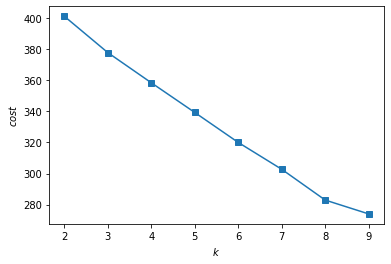

In [10]:
plt.plot(range(2, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$cost$');

In [11]:
train_inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(X_train_std)
    train_inertia.append(np.sqrt(kmeans.inertia_))

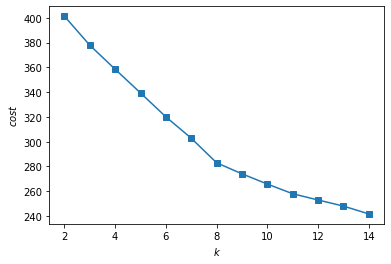

In [12]:
plt.plot(range(2, 15), train_inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$cost$');

(-0.1, 1)

(0, 27156)

For n_clusters = 2 The average silhouette_score is : 0.32844818698779726


Text(-0.05, 2089.0, '0')

Text(-0.05, 15662.0, '1')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27166)

For n_clusters = 3 The average silhouette_score is : 0.18861715772338955


Text(-0.05, 6074.5, '0')

Text(-0.05, 14139.5, '1')

Text(-0.05, 21648.0, '2')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27176)

For n_clusters = 4 The average silhouette_score is : 0.20703918941266108


Text(-0.05, 514.0, '0')

Text(-0.05, 7797.0, '1')

Text(-0.05, 16431.0, '2')

Text(-0.05, 22731.0, '3')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27186)

For n_clusters = 5 The average silhouette_score is : 0.2203973017765389


Text(-0.05, 1061.5, '0')

Text(-0.05, 6191.5, '1')

Text(-0.05, 12055.0, '2')

Text(-0.05, 20031.5, '3')

Text(-0.05, 26699.5, '4')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27196)

For n_clusters = 6 The average silhouette_score is : 0.2241874403541904


Text(-0.05, 1049.5, '0')

Text(-0.05, 6070.0, '1')

Text(-0.05, 11816.0, '2')

Text(-0.05, 19606.5, '3')

Text(-0.05, 26110.0, '4')

Text(-0.05, 26892.0, '5')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27206)

For n_clusters = 7 The average silhouette_score is : 0.22463313664549353


Text(-0.05, 907.0, '0')

Text(-0.05, 5583.5, '1')

Text(-0.05, 11059.5, '2')

Text(-0.05, 15786.0, '3')

Text(-0.05, 22292.0, '4')

Text(-0.05, 26070.0, '5')

Text(-0.05, 26784.0, '6')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27216)

For n_clusters = 8 The average silhouette_score is : 0.22561082044470085


Text(-0.05, 423.0, '0')

Text(-0.05, 4330.5, '1')

Text(-0.05, 10845.5, '2')

Text(-0.05, 14168.0, '3')

Text(-0.05, 16176.5, '4')

Text(-0.05, 17893.5, '5')

Text(-0.05, 21658.0, '6')

Text(-0.05, 26314.0, '7')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27226)

For n_clusters = 9 The average silhouette_score is : 0.2326211417939571


Text(-0.05, 3026.0, '0')

Text(-0.05, 6944.0, '1')

Text(-0.05, 11332.0, '2')

Text(-0.05, 15237.0, '3')

Text(-0.05, 15948.5, '4')

Text(-0.05, 16460.0, '5')

Text(-0.05, 20437.5, '6')

Text(-0.05, 25705.5, '7')

Text(-0.05, 27215.5, '8')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27236)

For n_clusters = 10 The average silhouette_score is : 0.2178001973604593


Text(-0.05, 406.0, '0')

Text(-0.05, 3786.5, '1')

Text(-0.05, 6979.5, '2')

Text(-0.05, 7480.0, '3')

Text(-0.05, 9238.5, '4')

Text(-0.05, 10715.5, '5')

Text(-0.05, 13916.5, '6')

Text(-0.05, 17975.5, '7')

Text(-0.05, 20896.5, '8')

Text(-0.05, 25092.5, '9')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27246)

For n_clusters = 11 The average silhouette_score is : 0.2227050482027169


Text(-0.05, 2972.0, '0')

Text(-0.05, 7990.5, '1')

Text(-0.05, 11465.5, '2')

Text(-0.05, 13487.5, '3')

Text(-0.05, 14486.5, '4')

Text(-0.05, 16878.0, '5')

Text(-0.05, 18874.5, '6')

Text(-0.05, 18953.5, '7')

Text(-0.05, 19241.5, '8')

Text(-0.05, 20287.0, '9')

Text(-0.05, 24179.5, '10')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27256)

For n_clusters = 12 The average silhouette_score is : 0.22256024308764066


Text(-0.05, 2886.5, '0')

Text(-0.05, 6357.0, '1')

Text(-0.05, 9771.5, '2')

Text(-0.05, 14547.0, '3')

Text(-0.05, 16570.5, '4')

Text(-0.05, 17642.0, '5')

Text(-0.05, 19034.5, '6')

Text(-0.05, 20841.0, '7')

Text(-0.05, 22464.5, '8')

Text(-0.05, 24664.0, '9')

Text(-0.05, 26946.0, '10')

Text(-0.05, 27245.5, '11')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27266)

For n_clusters = 13 The average silhouette_score is : 0.21929010810411592


Text(-0.05, 163.5, '0')

Text(-0.05, 3125.5, '1')

Text(-0.05, 6705.0, '2')

Text(-0.05, 8463.5, '3')

Text(-0.05, 9995.5, '4')

Text(-0.05, 12451.5, '5')

Text(-0.05, 14430.5, '6')

Text(-0.05, 14895.5, '7')

Text(-0.05, 18122.5, '8')

Text(-0.05, 21220.0, '9')

Text(-0.05, 22453.5, '10')

Text(-0.05, 23429.5, '11')

Text(-0.05, 25348.0, '12')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

(-0.1, 1)

(0, 27276)

For n_clusters = 14 The average silhouette_score is : 0.22134796301897072


Text(-0.05, 776.0, '0')

Text(-0.05, 2083.0, '1')

Text(-0.05, 5343.0, '2')

Text(-0.05, 8761.5, '3')

Text(-0.05, 9528.5, '4')

Text(-0.05, 10538.5, '5')

Text(-0.05, 11666.0, '6')

Text(-0.05, 12833.5, '7')

Text(-0.05, 13968.0, '8')

Text(-0.05, 15904.0, '9')

Text(-0.05, 17942.0, '10')

Text(-0.05, 18206.5, '11')

Text(-0.05, 20833.5, '12')

Text(-0.05, 25363.0, '13')

Text(0.5, 1.0, 'The silhouette plot for the various clusters.')

Text(0.5, 0, 'The silhouette coefficient values')

Text(0, 0.5, 'Cluster label')

[]

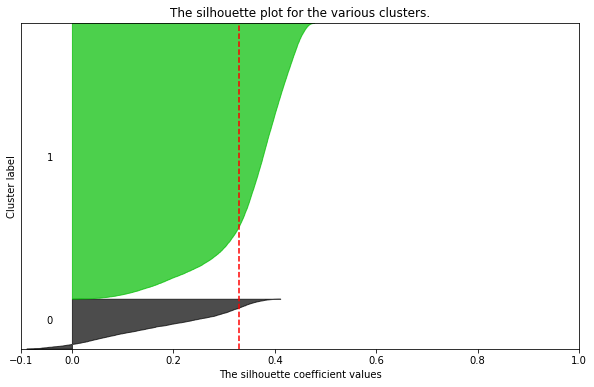

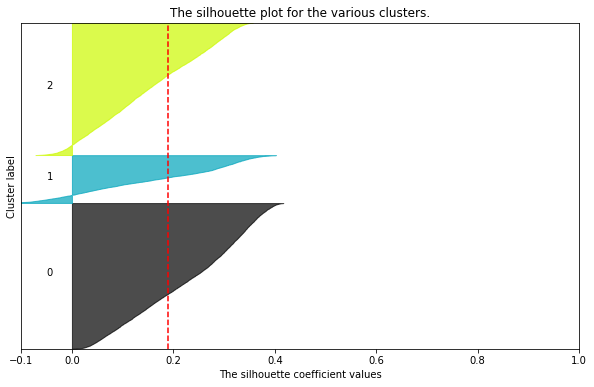

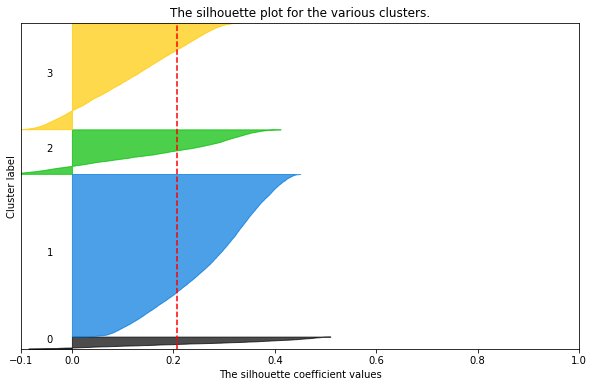

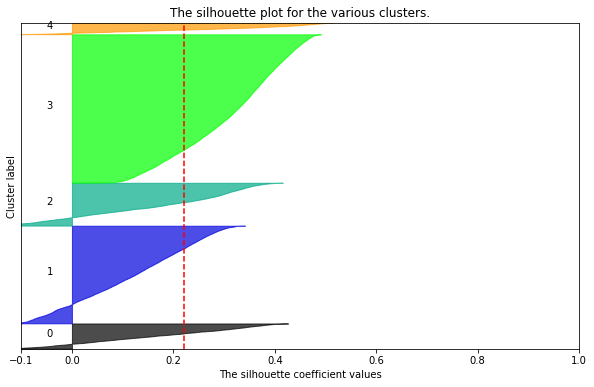

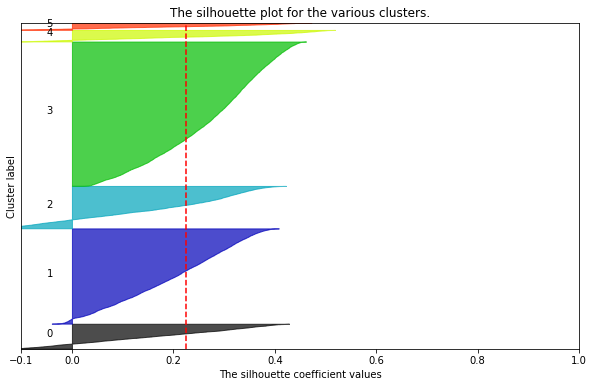

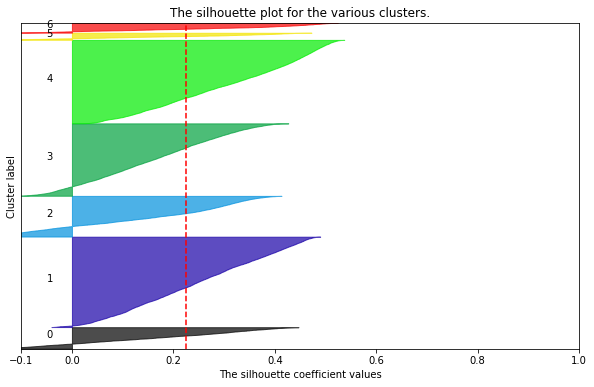

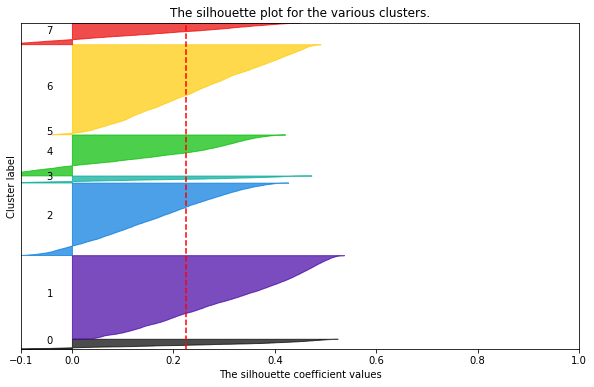

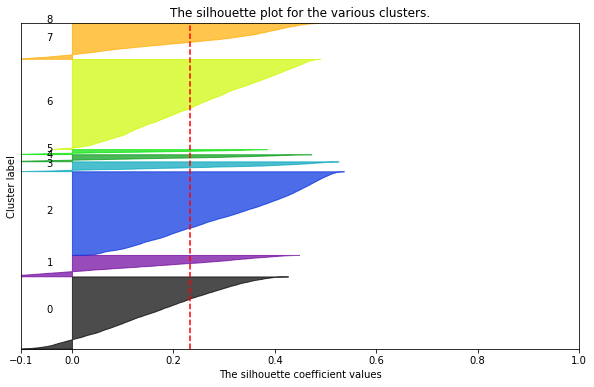

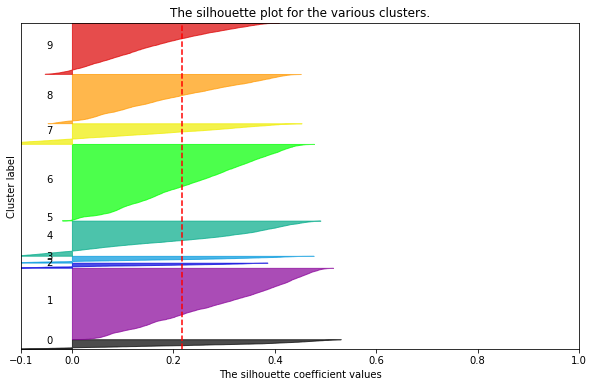

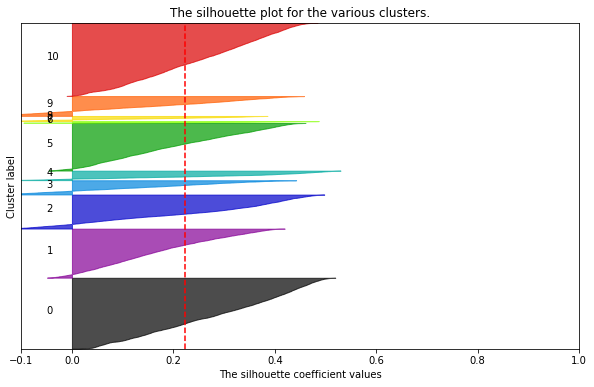

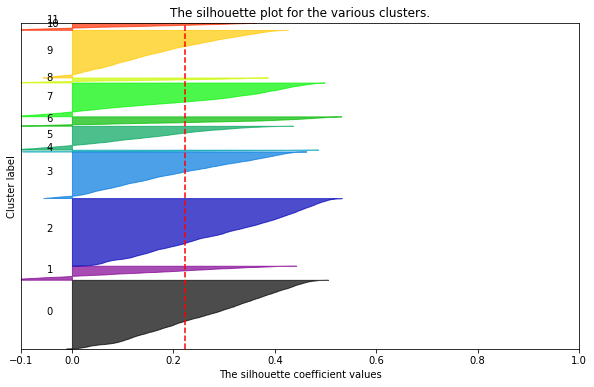

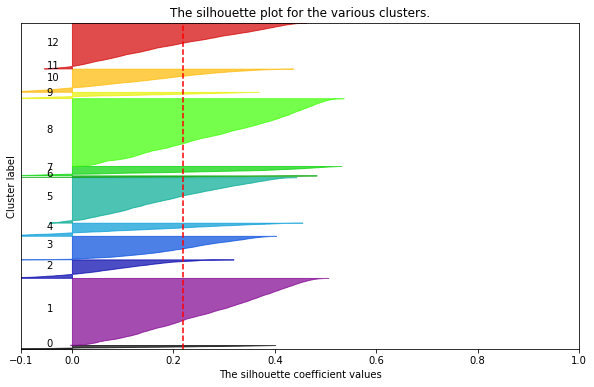

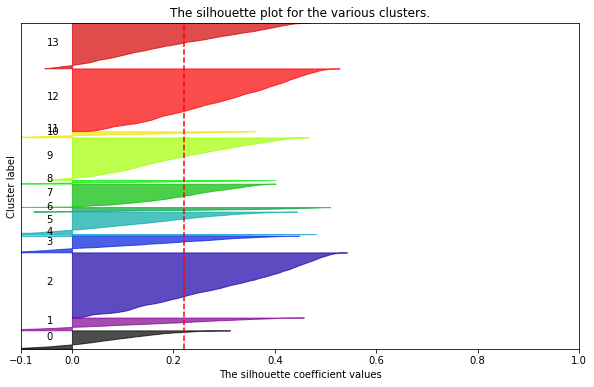

In [14]:
for n_clusters in list(range(2,15)):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111) 
    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_train_std) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state = seed)
    cluster_labels = clusterer.fit_predict(X_train_std)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train_std, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train_std, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

In [15]:
kmeans_cluster_9 = KMeans(n_clusters=9, random_state=0).fit(X_train_std)


In [36]:
with open('../data/processed/df_for_model_2.pkl', 'rb') as read_file:
    df_for_model_2 = pickle.load(read_file)   

In [70]:
#df_for_model_2 only has feature engineered categorical features
train_val_df, test_df = train_test_split(df_for_model_3, test_size=0.2,random_state=seed)
train_df, val_df = train_test_split(train_val_df, test_size=.25, random_state=seed)

In [71]:
train_df_copy = train_df.copy()
len(train_df_copy)
train_df_copy['k_means_centroid'] = kmeans_cluster_9.labels_
train_df_copy.head(2)

27126

,ID,cluster_predicted,age_group,balance_category,contact_label_encoded,current_engagement_bins,default_label_encoded,duration_bins,education_label_encoded,housing_label_encoded,job_label_encoded,marital_label_encoded,loan_label_encoded,month_label_encoded,poutcome_label_encoded,pdays_half_yearly_bins,prev_engagement_category,is_second_half_of_month,day,new_customers,y_label_encoded,cluster_predicted_0,cluster_predicted_1,cluster_predicted_2,cluster_predicted_3,cluster_predicted_4,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,"current_engagement_bins_[1, 2)","current_engagement_bins_[2, 6)","current_engagement_bins_[6, 11)","current_engagement_bins_[11, 64)",default_label_encoded_0,default_label_encoded_1,"duration_bins_[0, 60)","duration_bins_[60, 120)","duration_bins_[120, 300)","duration_bins_[300, 600)","duration_bins_[600, 900)","duration_bins_[900, 4919)",education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,housing_label_encoded_0,housing_label_encoded_1,job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,loan_label_encoded_0,loan_label_encoded_1,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"pdays_half_yearly_bins_[-1, 0)","pdays_half_yearly_bins_[0, 180)","pdays_half_yearly_bins_[180, 872)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)",is_second_half_of_month_0,is_second_half_of_month_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,new_customers_0,new_customers_1,age_group_label_encoded,balance_category_label_encoded,current_engagement_bins_label_encoded,duration_bins_label_encoded,pdays_half_yearly_bins_label_encoded,prev_engagement_category_label_encoded,age,balance,campaign,duration,previous,pdays,k_means_centroid
23354,16370,3,"[10, 30)","[-8019, 0)",0,"[2, 6)",0,"[120, 300)",1,0,1,2,1,7,3,"[-1, 0)","[0, 1)",1,23,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2,1,0,0,25,-2,2,273,0,-1,3
18555,16592,0,"[10, 30)","[0, 500)",1,"[1, 2)",0,"[60, 120)",1,1,9,1,1,7,3,"[-1, 0)","[0, 1)",1,24,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,3,0,0,28,158,1,77,0,-1,6


In [29]:
kmeans_centroids_df = pd.DataFrame(columns = kmeans_features.columns, data = kmeans_cluster_9.cluster_centers_)
kmeans_centroids_df

,age,balance,campaign,duration,day,previous,pdays
0,1.28,-0.02,-0.12,-0.20,-0.09,-0.15,-0.31
1,0.33,4.79,-0.10,-0.07,0.09,-0.04,-0.12
2,-0.03,-0.01,-0.11,2.79,-0.01,-0.13,-0.24
3,-0.46,-0.14,-0.07,-0.23,0.95,-0.19,-0.36
4,-0.18,-0.09,-0.23,-0.10,-0.27,0.72,2.41
5,-0.54,-0.19,-0.19,-0.18,-0.91,-0.19,-0.37
6,-0.03,-0.15,4.25,-0.46,0.75,-0.23,-0.40
7,0.00,0.02,0.08,-0.07,-0.17,4.35,1.76
8,-0.09,-0.28,-0.24,0.35,-1.66,108.94,2.20


In [72]:
val_kmeans_centroid = []
for i in range(X_val_std.shape[0]):
    val_hold_dist = []
    for j in range(kmeans_centroids_df.shape[0]):
        val_hold_dist.append(spatial.distance.cosine(X_val_std[i], kmeans_centroids_df.iloc[j]))
    
    val_kmeans_centroid.append(val_hold_dist.index(min(val_hold_dist)))

val_df['k_means_centroid'] = val_kmeans_centroid
val_df.head(2)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,cluster_predicted,age_group,balance_category,contact_label_encoded,current_engagement_bins,default_label_encoded,duration_bins,education_label_encoded,housing_label_encoded,job_label_encoded,marital_label_encoded,loan_label_encoded,month_label_encoded,poutcome_label_encoded,pdays_half_yearly_bins,prev_engagement_category,is_second_half_of_month,day,new_customers,y_label_encoded,cluster_predicted_0,cluster_predicted_1,cluster_predicted_2,cluster_predicted_3,cluster_predicted_4,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,"current_engagement_bins_[1, 2)","current_engagement_bins_[2, 6)","current_engagement_bins_[6, 11)","current_engagement_bins_[11, 64)",default_label_encoded_0,default_label_encoded_1,"duration_bins_[0, 60)","duration_bins_[60, 120)","duration_bins_[120, 300)","duration_bins_[300, 600)","duration_bins_[600, 900)","duration_bins_[900, 4919)",education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,housing_label_encoded_0,housing_label_encoded_1,job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,loan_label_encoded_0,loan_label_encoded_1,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"pdays_half_yearly_bins_[-1, 0)","pdays_half_yearly_bins_[0, 180)","pdays_half_yearly_bins_[180, 872)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)",is_second_half_of_month_0,is_second_half_of_month_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,new_customers_0,new_customers_1,age_group_label_encoded,balance_category_label_encoded,current_engagement_bins_label_encoded,duration_bins_label_encoded,pdays_half_yearly_bins_label_encoded,prev_engagement_category_label_encoded,age,balance,campaign,duration,previous,pdays,k_means_centroid
30254,14315,0,"[40, 50)","[0, 500)",0,"[2, 6)",0,"[300, 600)",1,0,1,1,0,7,3,"[-1, 0)","[0, 1)",0,14,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,2,2,0,0,48,101,3,549,0,-1,5
1743,21268,3,"[50, 60)","[0, 500)",0,"[6, 11)",0,"[0, 60)",0,1,5,1,1,8,3,"[-1, 0)","[0, 1)",1,18,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,3,0,0,0,54,11,10,48,0,-1,5


In [73]:
test_kmeans_centroid = []
for i in range(X_test_std.shape[0]):
    test_hold_dist = []
    for j in range(kmeans_centroids_df.shape[0]):
        test_hold_dist.append(spatial.distance.cosine(X_test_std[i], kmeans_centroids_df.iloc[j]))
    
    test_kmeans_centroid.append(test_hold_dist.index(min(test_hold_dist)))

test_df['k_means_centroid'] = test_kmeans_centroid
test_df.head(2)

/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,ID,cluster_predicted,age_group,balance_category,contact_label_encoded,current_engagement_bins,default_label_encoded,duration_bins,education_label_encoded,housing_label_encoded,job_label_encoded,marital_label_encoded,loan_label_encoded,month_label_encoded,poutcome_label_encoded,pdays_half_yearly_bins,prev_engagement_category,is_second_half_of_month,day,new_customers,y_label_encoded,cluster_predicted_0,cluster_predicted_1,cluster_predicted_2,cluster_predicted_3,cluster_predicted_4,"age_group_[10, 30)","age_group_[30, 40)","age_group_[40, 50)","age_group_[50, 60)","age_group_[60, 96)","balance_category_[-8019, 0)","balance_category_[0, 500)","balance_category_[500, 3000)","balance_category_[3000, 102128)",contact_label_encoded_0,contact_label_encoded_1,contact_label_encoded_2,"current_engagement_bins_[1, 2)","current_engagement_bins_[2, 6)","current_engagement_bins_[6, 11)","current_engagement_bins_[11, 64)",default_label_encoded_0,default_label_encoded_1,"duration_bins_[0, 60)","duration_bins_[60, 120)","duration_bins_[120, 300)","duration_bins_[300, 600)","duration_bins_[600, 900)","duration_bins_[900, 4919)",education_label_encoded_0,education_label_encoded_1,education_label_encoded_2,education_label_encoded_3,housing_label_encoded_0,housing_label_encoded_1,job_label_encoded_0,job_label_encoded_1,job_label_encoded_2,job_label_encoded_3,job_label_encoded_4,job_label_encoded_5,job_label_encoded_6,job_label_encoded_7,job_label_encoded_8,job_label_encoded_9,job_label_encoded_10,job_label_encoded_11,marital_label_encoded_0,marital_label_encoded_1,marital_label_encoded_2,loan_label_encoded_0,loan_label_encoded_1,month_label_encoded_1,month_label_encoded_2,month_label_encoded_3,month_label_encoded_4,month_label_encoded_5,month_label_encoded_6,month_label_encoded_7,month_label_encoded_8,month_label_encoded_9,month_label_encoded_10,month_label_encoded_11,month_label_encoded_12,poutcome_label_encoded_0,poutcome_label_encoded_1,poutcome_label_encoded_2,poutcome_label_encoded_3,"pdays_half_yearly_bins_[-1, 0)","pdays_half_yearly_bins_[0, 180)","pdays_half_yearly_bins_[180, 872)","prev_engagement_category_[0, 1)","prev_engagement_category_[1, 6)","prev_engagement_category_[6, 10)","prev_engagement_category_[10, 276)",is_second_half_of_month_0,is_second_half_of_month_1,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,new_customers_0,new_customers_1,age_group_label_encoded,balance_category_label_encoded,current_engagement_bins_label_encoded,duration_bins_label_encoded,pdays_half_yearly_bins_label_encoded,prev_engagement_category_label_encoded,age,balance,campaign,duration,previous,pdays,k_means_centroid
7281,43081,0,"[10, 30)","[0, 500)",0,"[2, 6)",0,"[600, 900)",0,0,1,2,0,2,3,"[-1, 0)","[0, 1)",1,19,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,4,0,0,27,377,2,645,0,-1,0
19469,20067,0,"[30, 40)","[0, 500)",0,"[2, 6)",0,"[120, 300)",0,0,3,1,0,8,3,"[-1, 0)","[0, 1)",0,8,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,1,0,0,37,189,4,148,0,-1,5


In [74]:
len(train_df_copy) + len(val_df) + len(test_df) == len(df_for_model_3)

True

In [75]:
with open('../data/processed/train_kmeans_9_clusters_df.pkl', 'wb') as to_write: ## train_set with kmeans centroids
    pickle.dump(train_df_copy, to_write) 
with open('../data/processed/val_kmeans_9_clusters_df.pkl', 'wb') as to_write: ## val_set with kmeans centroids
    pickle.dump(val_df, to_write) 
with open('../data/processed/test_kmeans_9_clusters_df.pkl', 'wb') as to_write: ## test_set with kmeans centroids
    pickle.dump(test_df, to_write)     

In [76]:
kmeans_cluster_2 = KMeans(n_clusters=2, random_state=0).fit(X_train_std)

kmeans_2_centroids_df = pd.DataFrame(columns = kmeans_features.columns, data = kmeans_cluster_2.cluster_centers_)
kmeans_2_centroids_df

,age,balance,campaign,duration,day,previous,pdays
0,0.00,-0.01,0.04,-0.00,0.04,-0.21,-0.38
1,-0.03,0.05,-0.20,0.01,-0.21,1.15,2.11
